In [1]:
import os
import unittest

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Комментарий к выполнению тестового задания:

На протяжении времени выполнения ТЗ я часто менял методы решения его пунктов. Я попробовал разные варианты и напишу их здесь. Скажите, пожалуйста, если я неправильно интерпретировал задачи, я быстро их переделаю(у меня есть все сохранения :) ).

---

Вариант 1:
В задании 2: "Реализуйте чтение датасета в pandas DataFrame с обязательными колонками "document_id", "document_text", "entity", "gold_answer"."
<br>Колонки 'entity', 'gold_answer' в единственном числе(а не entities и gold_answers), поэтому изначально я пошёл по этому пути и **выписывал каждый ответ и соответствующую ему entity построчно**.
<br>В следствии, дойдя до 5го задания, которое требует расчёта метрик для оценки, столкнулся с тем, что, по сути, **типичные f-статистика, полнота и точность(precision) - не имеют особого смысла**, т.к. мы сравниваем один полный ответ с другим полным ответом и тут **логичнее использовать точность, в том смысле, что** каждую gold строку сравнивать с перебираемыми строками в pred(перебираемыми, потому что, по идеи, мы не будем каждый раз выписывать ответы LLM соответсвенно эталоном, хотя заполнение ответов LLM в соответствии с gold упростило бы сравнение) и впоследствии вычислять среднее значение для документа или сущности.

---

Вариант 2:
Однако подумав(и спросив у квестгивера :) ), решил, что точность, в смысле, описанном выше, вряд ли подразумевалась и **следует использовать** типичную для задач извлечения именованных сущностей, **F-статистику**, тогда сагрегировал сущности(entity) и вывел к ним в соответствие строку с разделёнными ';' ответами. То же проделал для ответов gigachat и применил метрики: f-статистику, полноту и точность(precision). Тут мы уже сравниваем несколько ответов и данные метрики вполне подходят(ответ будет не 1 или 0, а именно что от 0.0 до 1.0).

---

<details>
  <summary>Стыд</summary>
  там ещё технические шоколадки с векторной реализацией случились, самое интересное - там :)
</details>

## Задание 1:

**Опишите задачу с точки зрения NLP.
<br>Что это за задача, какие классические методы существуют для ее решения?
<br>Как ее можно решать через LLM?
<br>Как обычно оценивают качество моделей в этой задаче?**

---

Задача распознавания именованных сущностей (Named Entity Recognition, NER) заключается в выявлении и категоризации отрезков текста, которые представляют собой имена собственные, такие как имена людей, названия организаций, географические объекты и другие.
<br>Это одна из ключевых задач NLP, направленная на извлечение структурированной информации из неструктурированных текстов.

Классический подход к решению задачи NER состоит в пословной разметке текста с использованием BIO-нотации. В этой системе:

* B-метка (beginning) указывает на начало сущности,
* I-метка (inside) отмечает слова внутри сущности,
* O-метка (outside) используется для слов, не относящихся к сущностям.
<br>BIO-нотация помогает точно определить границы именованных сущностей и их типы.

Из текста: Илон Маск запустил ракету
На выходе мы получим сущности в виде: [Категория сущности]-[Именованная сущность]
<br>Например: PER-Elon-Musk

---

Правильно составив запрос и описав задачу, можно обратиться к LLM, отдав ей на вход запрос с интересующими нас сущностями и их описанием, и текст для анализа, а получить список сущностей из текста.

---

Обычно качество моделей оценивают с помощью точности, полноты и F-меры.
* Единицей для расчета этих метрик считается сущность.
* Точность определяется как отношение количества правильно распознанных сущностей и количества распознанных сущностей
* Полнота – как отношение правильно распознанных сущностей и количества сущностей в золотом стандарте.
* F-мера объединяет в себе две предыдущие метрики.

## Задание 2:

**Реализуйте чтение датасета в pandas DataFrame с обязательными колонками "document_id", "document_text", "entity", "gold_answer".
<br>Выведите шапку датафрейма.**

In [2]:
# Пути к директориям
raw_folder = 'sample_pl_cs_ru_bg/raw/ru'
annotated_folder = 'sample_pl_cs_ru_bg/annotated/ru'

In [3]:
# Список файлов
raw_files = sorted([f for f in os.listdir(raw_folder) if f.endswith(".txt")])
annotated_files = sorted([f for f in os.listdir(annotated_folder) if f.endswith(".out")])

In [4]:
# Список строк для DataFrame
rows = []
# Данные из файлов с ответами
for annotated_file in annotated_files:
    # Читаем файл
    with open(os.path.join(annotated_folder, annotated_file), 'r', encoding='utf-8') as file:
        lines = file.readlines()
        # Определяем document_id (он указан в первой строке)
        document_id = lines[0].strip() #strip - уберёт лишние пробелы

        # Построчно извлекаем сущности и ответы(gold)
        entities = {}
        
        for line in lines:
            parts = line.split('\t') # делим по табуляциям, т.к. в док-ах именно такое разделение
            if len(parts) >= 4:  # Проверяем, что строка без пропусков
                
                entity = parts[2].strip()
                gold = parts[3].strip()

                # формируем пары сущность:ответы
                if entity not in entities:
                    entities[entity] = []
                if gold not in entities[entity]:
                    entities[entity].append(gold)

        # Добавляем сущности и ответы в фрейм
        for entity, golds in entities.items():
            rows.append([
                document_id,
                None,  # document_text будет добавлен ниже
                entity,
                "; ".join(golds)  # Объединяем ответы через ";"
            ])

In [5]:
# Данные из файлов с "сырым" текстом
raw_texts = {}
for raw_file in raw_files:
    # Читаем файл
    with open(os.path.join(raw_folder, raw_file), 'r', encoding='utf-8') as file:
        lines = file.readlines()
        # Определяем document_id из первой строки
        document_id = lines[0].strip()
        # Убираем первые 4 строки и записываем оставшийся текст
        document_text = "".join(lines[4:]).strip()
        # записываем в словарь
        raw_texts[document_id] = document_text

In [6]:
# Создаём DataFrame
df = pd.DataFrame(rows, columns=['document_id', 'document_text', 'entity', 'gold_answer']) # здесь же заполняем всё, кроме текста

# Добавляем текст документа в соответствии с айди
df['document_text'] = df['document_id'].map(raw_texts)

In [7]:
# Выводим "шапку" фрейма
df.head()

,document_id,document_text,entity,gold_answer
0,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,EVT,EVT-Brexit
1,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,LOC,GPE-Great-Britain; GPE-Brussles; LOC-Europe; L...
2,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,PER,PER-Boris-Johnson; PER-Michel-Barnier; PER-The...
3,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,ORG,ORG-European-Union; ORG-European-Commission; O...
4,ru-1000,Подробности.ua: Третий за сутки: Борис Джонсон...,EVT,EVT-Brexit


## Задание 3:

**Напишите функцию, которая принимает на вход строку датафрейма и выдает текст входного сообщения для LLM.**

---

**Функция:**

In [8]:
def create_llm_input_msg(row):
    '''
    Функция принимает на вход строку DataFrame и возвращает текст входного сообщения для LLM.
    
    Параметры:
        row (pandas.Series): строка DataFrame, содержащая данные документа.
        
    Возвращает:
        str: текст сообщения для LLM.
    '''
    msg = f'Задача: Извлечь из новостной статьи именованные сущности(NER - Named Entity Recognition).\n'
    msg += f'Категории сущностей: {row["entity"]}\n\n'
    msg += f'Вывод должен содержать ответ для каждой сущности, записанный построчно, в формате: [Категория сущности]-[Именованная сущность]\n'
    msg += f'Например: {row["gold_answer"].split(';')[0]}\n\n' # используем только первый ответ, в качестве примера
    msg += f'Важные условия:\n1)Ответ должен быть на английском языке.\n2)Если именованная сущность составная, т.е. разделена пробелами, то пробелы заменяй на дефисы(-).\n\n'
    msg += f'Текст для анализа:\n{row["document_text"]}'
    
    return msg

**Пример использования:**

In [9]:
# Применяем функцию к первой строке
print(create_llm_input_msg(df.iloc[0]))

Задача: Извлечь из новостной статьи именованные сущности(NER - Named Entity Recognition).
Категории сущностей: EVT

Вывод должен содержать ответ для каждой сущности, записанный построчно, в формате: [Категория сущности]-[Именованная сущность]
Например: EVT-Brexit

Важные условия:
1)Ответ должен быть на английском языке.
2)Если именованная сущность составная, т.е. разделена пробелами, то пробелы заменяй на дефисы(-).

Текст для анализа:
Тереза Мэй рассчитывает усидеть в седле до завершения процедуры Brexit

Тем не менее, по сведениям британских СМИ, на предстоящей в конце сентября конференции партии тори противники Мэй навяжут ей серьезный бой, из которого не факт, что она выйдет победителем. Фаворит букмекеров в качестве возможного сменщика нынешнего премьера, бывший министр иностранных дел Британии Борис Джонсон намерен выступить с альтернативным докладом, который не оставит камня на камне от взглядов главы правительства на условия "брекзита". С точки зрения Джонсона, "Лондон обернул 

## Задание 4:

**Получите ответы GigaChat для всех документов. Документов всего 9, поэтому сделать это можно вручную, пользуясь веб-интерфейсом GigaChat или ботом в ВК или Телеграме. Не очищайте историю сообщений, чтобы потом продемонстрировать подлинность ответов на онлайн-собеседовании.**

**Внесите ответы GigaChat в датафрейм, сохраните его.**

---

**Пример запроса:**
<br>*Категории сущностей описаны в виде краткой выдержки, из приложенного ["гайда"](https://bsnlp.cs.helsinki.fi/bsnlp-2019/Guidelines_20190122.pdf).*

```
Задача: Извлечь из новостной статьи именованные сущности.

Категории сущностей:
   - PER (личность): Имена отдельных людей или семей, а также группы людей, связанные с геополитическими единицами. Не включать титулы, должности или функции. Например, "Theresa May" или "Russians" (в контексте граждан России).  
   - LOC (местоположение): Географические объекты, включая города, страны, регионы, природные и искусственные сооружения (например, "Łazienki Królewskie w Warszawie" или "Schiphol airport"). Упоминания стран или геополитических единиц (GPE), таких как "Poland" или "United States", относятся к категории GPE.
   - EVT (событие): Упоминания событий, таких как конференции, войны, катастрофы, а также будущие или вымышленные события. Например, "Chernobyl catastrophe" или "Święta Bożego Narodzenia".
   - ORG (организация): Названия организаций, включая политические партии, компании, НПО, международные организации, спортивные команды и другие группы, такие как "European Union" или "Citi Handlowy w Poznaniu".
   - PRO (продукт): Продукты, такие как электроника, автомобили, книги, фильмы, программное обеспечение и другие товары или услуги. Бренды и модели. Например, "Motorola Moto Z Play" или "Harry Potter and the Sorcerer's Stone".

Вывод должен содержать ответ для каждой сущности, записанный построчно, в формате: [Категория сущности]-[Именованная сущность]

Например:
    PER-Theresa-May
    GPE-Warsaw
    LOC-Asia
    EVT-Chernobyl-catastrophe
    ORG-European-Union
    PRO-Motorola

Важные условия:
   - Ответ должен быть на английском языке.
   - Если именованная сущность составная, т.е. разделена пробелами, то пробелы заменяй на дефисы.

Текст для анализа в прикреплённом файле brexit_ru.txt_file_10.txt.
Используй только указанный файл.
```

---

**Для загрузки ответов GigaChat решил написать функцию, хотя можно было и вручную всё это внести, подумал, что для каждого документа и каждой сущности вносить изменения будет долго:**

In [10]:
def upload_giga_answer(df, document_id, giga_answers):
    """
    Добавляет ответы giga_answer в DataFrame, распределяя их по entity, включая записи GPE в LOC.

    Параметры:
        df (pd.DataFrame): DataFrame с колонками 'document_id', 'entity', 'gold_answer', 'giga_answer'.
        document_id (str): Идентификатор документа, для которого добавляются ответы.
        giga_answers (list): Список ответов (например, ["PER-Theresa-May", "GPE-Britain"]).
        
    Возвращает:
        pd.DataFrame: Обновлённый DataFrame с заполненным столбцом 'giga_answer'.
    """
    # Фильтруем строки для данного document_id
    df_doc = df[df['document_id'] == document_id].copy()

    #Словарь для хранения новых значений 'giga_answer'(сущности выбираем из исходного фрейма)
    giga_dict = {entity: [] for entity in df_doc['entity'].unique()}

    # Распределяем ответы из giga_answers по категориям (entity)
    for answer in giga_answers:
        entity_category = answer[:3]  # Первые три символа (категория сущности)
        if entity_category in giga_dict:
            giga_dict[entity_category].append(answer)
        if entity_category == 'GPE' and 'LOC' in giga_dict:
            giga_dict['LOC'].append(answer)  # Условие, которое учитывает, что ответы с GPE относятся к сущности LOC

    # Преобразуем ответы в строки с разделителем - ';'
    giga_dict = {key: "; ".join(values) for key, values in giga_dict.items()}

    # Записываем результаты в фрейм
    for index, row in df_doc.iterrows():
        entity = row['entity']
        df.loc[index, 'giga_answer'] = giga_dict.get(entity, '')

    return df

### Внесение данных в фрейм:

*Забегая наперёд, я не смог добиться, чтобы giga_chat нашёл сущности PRO*

In [11]:
giga_answer_10 = ["PER-Theresa-May", "PER-Boris-Johnson", "GPE-Britain", "GPE-London",  "GPE-Brussels", "GPE-Northern-Ireland", "LOC-La-Manche",
                  "EVT-Brexit", "EVT-Emergency-summit-of-the-EU", "EVT-Conference-of-the-Conservative-Party", "ORG-Conservative-Party",
                  "ORG-European-Union", "ORG-International-Monetary-Fund"]

giga_answer_1000 = ["PER-Boris-Johnson", "PER-Theresa-May", "PER-David-Davis", "PER-Steve-Baker", "GPE-United-Kingdom", "EVT-Resignation",
                    "EVT-Negotiations-with-the-EU", "ORG-UK-Cabinet", "ORG-UK-Foreign-Office", "ORG-European-Union"]

giga_answer_1001 = ["PER-Boris-Johnson", "PER-Theresa-May", "PER-Associated-Press", "GPE-United-Kingdom", "EVT-Resignation-of-Boris-Johnson",
                    "EVT-Brexit", "ORG-UK-Government", "ORG-UK-Prime-Ministers-Office"]

giga_answer_1002 = ["PER-Theresa-May", "PER-Boris-Johnson", "PER-David-Davis", "GPE-United-Kingdom", "EVT-Resignation", "EVT-Brexit"]

giga_answer_1003 = ["PER-Boris-Johnson", "PER-Theresa-May", "PER-David-Davis", "GPE-United-Kingdom", "EVT-Resignation", "ORG-UK-Government"]

giga_answer_1004 = ["PER-Boris-Johnson", "PER-Theresa-May", "PER-David-Davis", "GPE-United-Kingdom", "GPE-London", "LOC-Western-Balkans",
                    "EVT-Resignation-of-Boris-Johnson", "EVT-Resignation-of-David-Davis", "EVT-Press-conference-in-London",
                    "EVT-Summit-on-the-development-of-the-Western-Balkans-region", "ORG-UK-Government", "ORG-UK-Prime-Minister-s-Office",
                    "ORG-Conservative-Party"]

giga_answer_1006 = ["PER-Maria-Zakharova", "PER-Boris-Johnson", "PER-Theresa-May", "GPE-Russia", "EVT-Resignation-of-Boris-Johnson",
                    "ORG-UK-Government", "ORG-European-Union"]

giga_answer_1011 = ["PER-Boris-Johnson", "PER-Theresa-May", "PER-David-Davis", "GPE-United-Kingdom", "EVT-Resignation-of-Boris-Johnson",
                    "EVT-Resignation-of-David-Davis", "EVT-Brexit",  "ORG-UK-Government", "ORG-Guardian"]

giga_answer_1017 = ["PER-Boris-Johnson", "PER-Theresa-May", "PER-David-Davis", "PER-Steve-Baker", "GPE-United-Kingdom", "EVT-Resignation",
                    "ORG-UK-Parliament", "ORG-UK-Government"]

In [12]:
df = upload_giga_answer(df, 'ru-10', giga_answer_10)
df = upload_giga_answer(df, 'ru-1000', giga_answer_1000)
df = upload_giga_answer(df, 'ru-1001', giga_answer_1001)
df = upload_giga_answer(df, 'ru-1002', giga_answer_1002)
df = upload_giga_answer(df, 'ru-1003', giga_answer_1003)
df = upload_giga_answer(df, 'ru-1004', giga_answer_1004)
df = upload_giga_answer(df, 'ru-1006', giga_answer_1006)
df = upload_giga_answer(df, 'ru-1011', giga_answer_1011)
df = upload_giga_answer(df, 'ru-1017', giga_answer_1017)

In [13]:
# Проверяем результат
df[df["document_id"] == "ru-10"]

,document_id,document_text,entity,gold_answer,giga_answer
0,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,EVT,EVT-Brexit,EVT-Brexit; EVT-Emergency-summit-of-the-EU; EV...
1,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,LOC,GPE-Great-Britain; GPE-Brussles; LOC-Europe; L...,GPE-Britain; GPE-London; GPE-Brussels; GPE-Nor...
2,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,PER,PER-Boris-Johnson; PER-Michel-Barnier; PER-The...,PER-Theresa-May; PER-Boris-Johnson
3,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,ORG,ORG-European-Union; ORG-European-Commission; O...,ORG-Conservative-Party; ORG-European-Union; OR...


## Задание 5:

**Реализуйте самостоятельно алгоритм для подсчета метрик score_fn(gold: str, pred: str) → float.
<br>Можно пользоваться только библиотеками numpy, scipy, pandas.
<br>Напишите юнит-тесты.
<br>Возможно ли ускорить вычисление функции через векторную реализацию?
<br>Поясните решение и обоснуйте, почему выбрали именно такую метрику.**

---

**Выбор метрик:**

[Типичными метриками](https://learn.microsoft.com/ru-ru/azure/ai-services/language-service/custom-named-entity-recognition/concepts/evaluation-metrics) для оценки моделей распознавания именованных сущностей является:

* **Точность:** измеряет, насколько точна модель. Представляет собой соотношение между правильно определенными положительными (истинноположительными) результатами и всеми определенными положительными значениями. Метрика точности показывает, сколько из спрогнозированных сущностей правильно помечено метками.
```Precision = #True_Positive / (#True_Positive + #False_Positive)```

* **Полнота:** измеряет способность модели прогнозировать фактические положительные классы. Это отношение между спрогнозированными истинноположительными результатами и фактически помеченными значениями. Метрика полноты показывает, сколько из прогнозируемых сущностей определено верно.
```Recall = #True_Positive / (#True_Positive + #False_Negatives)```

* **F-мера:** зависит от точности и полноты. Она необходима при поиске баланса между точностью и полнотой.
```F1 Score = 2 * Precision * Recall / (Precision + Recall)```

В конечном счёте была **выбрана F-мера т.к. она учитывает и точность, и полноту**

### Алгоритм подсчёта метрик:

In [14]:
def score_fn(gold: str, pred: str) -> float:
    """
    Вычисляет F-метрику между эталонным текстом и предсказанным текстом.
    
    Параметры:
        gold (str): Эталонный текст с сущностями.
        pred (str): Предсказанный текст с сущностями.
        
    Возвращает:
        float: Значение F-метрики.
    """
    # Проверяем пустые строки
    if not gold and not pred:
        return 0.0
    
    # Разделяем сущности по разделителю ";" и преобразуем в множества
    gold_entities = set(gold.split(';')) if gold else set()
    pred_entities = set(pred.split(';')) if pred else set()

    # Убираем лишние пробелы из сущностей
    gold_entities = {entity.strip() for entity in gold_entities}
    pred_entities = {entity.strip() for entity in pred_entities}
    
    # Вычисляем TP, FP и FN
    true_positive = len(gold_entities & pred_entities)
    false_positive = len(pred_entities - gold_entities)
    false_negative = len(gold_entities - pred_entities)
    
    # Вычисляем точность, полноту
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    
    # F-метрика
    if precision + recall == 0:
        return 0.0
    f_score = 2 * (precision * recall) / (precision + recall)
    return f_score

**Применение:**

In [15]:
gold = df.loc[3, 'gold_answer'] # сущность ORG для текста ru-10
pred = df.loc[3, 'giga_answer']

score_fn(gold, pred)

0.4

### Юнит тесты:

* **test_full_match:** Проверка полного совпадения эталонного и предсказанного текста (F1 = 1.0).
* **test_partial_match:** Проверка частичного совпадения (F1 между 0 и 1).
* **test_no_match:** Проверка полного несовпадения (F1 = 0.0).
* **test_empty_gold:** Проверка пустого эталонного текста (F1 = 0.0).
* **test_empty_pred:** Проверка пустого предсказания (F1 = 0.0).
* **test_empty_both:** Проверка пустых обоих текстов (F1 = 0.0).
* **test_repeated_entities:** Проверка повторяющихся сущностей в эталоне, при которых F1 не меняется.
* **test_gold_with_extra_spaces:** Проверка эталонного текста с лишними пробелами (F1 = 1.0).
* **test_pred_with_extra_spaces:** Проверка предсказания с лишними пробелами (F1 = 1.0).
* **test_both_with_extra_spaces:** Проверка обоих текстов с лишними пробелами (F1 = 1.0).
* **test_mixed_spaces_and_match:** Проверка частичного совпадения с пробелами в эталоне и предсказании (F1 между 0 и 1).

In [16]:
import unittest

# Определяем тесты
class TestScoreFn(unittest.TestCase):
    
    def test_full_match(self):
        """Полное совпадение: F1 = 1.0"""
        gold = "PER: Борис Джонсон; LOC: Великобритания"
        pred = "PER: Борис Джонсон; LOC: Великобритания"
        self.assertAlmostEqual(score_fn(gold, pred), 1.0)

    def test_partial_match(self):
        """Частичное совпадение: F1 между 0 и 1"""
        gold = "PER: Борис Джонсон; LOC: Великобритания"
        pred = "PER: Борис Джонсон; LOC: Лондон"
        self.assertAlmostEqual(score_fn(gold, pred), 0.5)

    def test_no_match(self):
        """Полное несовпадение: F1 = 0.0"""
        gold = "PER: Борис Джонсон; LOC: Великобритания"
        pred = "ORG: ООН; EVT: Brexit"
        self.assertAlmostEqual(score_fn(gold, pred), 0.0)

    def test_empty_gold(self):
        """Пустой эталон: F1 = 0.0"""
        gold = ""
        pred = "PER: Борис Джонсон"
        self.assertAlmostEqual(score_fn(gold, pred), 0.0)

    def test_empty_pred(self):
        """Пустое предсказание: F1 = 0.0"""
        gold = "PER: Борис Джонсон"
        pred = ""
        self.assertAlmostEqual(score_fn(gold, pred), 0.0)

    def test_empty_both(self):
        """Оба текста пусты: F1 = 0.0"""
        gold = ""
        pred = ""
        self.assertAlmostEqual(score_fn(gold, pred), 0.0)

    def test_repeated_entities(self):
        """Повторяющиеся сущности: F1 не изменяется"""
        gold = "PER: Борис Джонсон; PER: Борис Джонсон"
        pred = "PER: Борис Джонсон"
        self.assertAlmostEqual(score_fn(gold, pred), 1.0)

    def test_gold_with_extra_spaces(self):
        """Пробелы в эталоне: F1 = 1.0"""
        gold = "PER: Борис Джонсон ; LOC: Великобритания "
        pred = "PER: Борис Джонсон; LOC: Великобритания"
        self.assertAlmostEqual(score_fn(gold, pred), 1.0)

    def test_pred_with_extra_spaces(self):
        """Пробелы в предсказании: F1 = 1.0"""
        gold = "PER: Борис Джонсон; LOC: Великобритания"
        pred = "PER: Борис Джонсон ; LOC: Великобритания "
        self.assertAlmostEqual(score_fn(gold, pred), 1.0)

    def test_both_with_extra_spaces(self):
        """Пробелы в обоих текстах: F1 = 1.0"""
        gold = "PER: Борис Джонсон ; LOC: Великобритания "
        pred = "PER: Борис Джонсон ; LOC: Великобритания "
        self.assertAlmostEqual(score_fn(gold, pred), 1.0)

    def test_mixed_spaces_and_match(self):
        """Пробелы в эталоне и предсказании: F1 между 0 и 1"""
        gold = "PER: Борис Джонсон; LOC: Великобритания"
        pred = "PER: Борис Джонсон ; LOC: Лондон"
        self.assertAlmostEqual(score_fn(gold, pred), 0.5)

**Применение:**

In [17]:
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestScoreFn))# gpt сказал это верный запуск теста(остальные "конфликтуют")

...........
----------------------------------------------------------------------
Ran 11 tests in 0.008s

OK


<unittest.runner.TextTestResult run=11 errors=0 failures=0>

### Вычисление через векторы:

*Преобразуем строки в массивы numpy и, с их помощью, вычисляем метрики*

In [18]:
def vector_score_fn(gold: str, pred: str) -> float:
    """
    Вычисляет F-метрику между эталонным текстом и предсказанным текстом с использованием NumPy.

    Параметры:
        gold (str): Эталонный текст с сущностями.
        pred (str): Предсказанный текст с сущностями.

    Возвращает:
        float: Значение F-метрики.
    """
    # Проверяем пустые строки
    if not gold and not pred:
        return 0.0

    # Разделяем сущности по ";", убираем лишние пробелы и создаём векторы
    gold_entities = np.array([entity.strip() for entity in gold.split(";")])
    pred_entities = np.array([entity.strip() for entity in pred.split(";")])

    # Проверяем, есть ли сущности
    if gold_entities.size == 0 and pred_entities.size == 0:
        return 0.0

    # Вычисляем пересечение (True Positives)
    true_positive = np.sum(np.isin(pred_entities, gold_entities))
    # Вычисляем FP и FN
    false_positive = np.sum(np.isin(pred_entities, gold_entities, invert=True))
    false_negative = np.sum(np.isin(gold_entities, pred_entities, invert=True))

    # Вычисляем точность и полноту
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0.0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0

    # Вычисляем F1-метрику
    if precision + recall == 0:
        return 0.0
    
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

**Применение:**

In [19]:
vector_score_fn(gold, pred)

np.float64(0.4)

*для последующего корректного сравнения, я посчитал важным, чтобы этапы в функциях соотвествовали друг другу*

### Сравнение скорости(тут смеятся):

In [20]:
%timeit score_fn(gold, pred)
%timeit vector_score_fn(gold, pred)

2.32 μs ± 20.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
69.4 μs ± 8.73 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


**Вывод говорит о том, что реализация через векторы выполняется дольше, что противоречит самому смыслу существования NumPy.**

*Сколько бы я не пытался, какие бы способы не применил и как бы сильно не достал gpt, у меня не получилось ускорить функцию векторизацией.*

**Причину я не выяснил(и там, и там - последовательность строк, но в случае с векторами, над ними должны выполняться векторные операции, которые работают быстрее относительно обычных операций, но видимо, я что-то упустил..).**

---

**Думал на больших наборах данных можно будет заметить увеличение скорости, но там всё ещё хуже, чем больше данных, тем кратно дольше выполняется расчёт..**

In [22]:
import time
# Определяем тестовые данные
test_data = [
    ("entity1; entity2; entity3", "entity2; entity3; entity4"),
    ("entity1; entity2", "entity2; entity3"),
    ("", ""),
    ("entity1", "entity1"),
    ("entity1; entity2; entity3", ""),
    ("", "entity1; entity2"),
] * 100000  # Увеличиваем размер теста для более значимого сравнения

# Сравнение производительности
# Векторная функция
start_time_vectorized = time.time()
vector_results = [vector_score_fn(gold, pred) for gold, pred in test_data]
end_time_vectorized = time.time()
time_vectorized = end_time_vectorized - start_time_vectorized

# Обычная функция
start_time_set = time.time()
set_results = [score_fn(gold, pred) for gold, pred in test_data]
end_time_set = time.time()
time_set = end_time_set - start_time_set

# Вывод времени выполнения и корректности
print(f"Время выполнения vector_score_fn: {time_vectorized:.6f} секунд")
print(f"Время выполнения score_fn: {time_set:.6f} секунд")
print(f"Результаты совпадают: {vector_results == set_results}")

Время выполнения vector_score_fn: 20.073940 секунд
Время выполнения score_fn: 0.617445 секунд
Результаты совпадают: True


**тут можно поиграться с наборами через рандом чойс, но думаю всё и так очевидно**

## Задание 6

**Вычислите метрики для каждой строки в датафрейме. Сагрегируйте результаты а) по каждой сущности, б) по каждому документу. Изобразите результаты на графиках. Какие выводы можно сделать?**

---

### Вычисление метрик для каждой строки:


In [23]:
df['score'] = df.apply(lambda row: score_fn(row['gold_answer'], row['giga_answer']), axis=1)

In [24]:
df[df["document_id"] == "ru-1000"]

,document_id,document_text,entity,gold_answer,giga_answer,score
4,ru-1000,Подробности.ua: Третий за сутки: Борис Джонсон...,EVT,EVT-Brexit,EVT-Resignation; EVT-Negotiations-with-the-EU,0.000000
5,ru-1000,Подробности.ua: Третий за сутки: Борис Джонсон...,PRO,PRO-The-Guardian; PRO-Podrobnosti,,0.000000
6,ru-1000,Подробности.ua: Третий за сутки: Борис Джонсон...,PER,PER-Boris-Johnson; PER-David-Davis; PER-Steve-...,PER-Boris-Johnson; PER-Theresa-May; PER-David-...,1.000000
7,ru-1000,Подробности.ua: Третий за сутки: Борис Джонсон...,LOC,GPE-Great-Britain,GPE-United-Kingdom,0.000000
8,ru-1000,Подробности.ua: Третий за сутки: Борис Джонсон...,ORG,ORG-European-Union; ORG-Foreign-Office; ORG-UNN,ORG-UK-Cabinet; ORG-UK-Foreign-Office; ORG-Eur...,0.333333


### Агрегация:

In [25]:
# Агрегация по каждой сущности
ent_agg = df.groupby('entity')['score'].mean().reset_index()

print("Агрегация по каждой сущности:")
ent_agg

Агрегация по каждой сущности:


,entity,score
0,EVT,0.259259
1,LOC,0.072150
2,ORG,0.081481
3,PER,0.903704
4,PRO,0.000000


In [26]:
# Агрегация по каждому документу
doc_agg = df.groupby('document_id')['score'].mean().reset_index()

print("Агрегация по каждому документу:")
doc_agg

Агрегация по каждому документу:


,document_id,score
0,ru-10,0.482576
1,ru-1000,0.266667
2,ru-1001,0.366667
3,ru-1002,0.416667
4,ru-1003,0.250000
5,ru-1004,0.321429
6,ru-1006,0.133333
7,ru-1011,0.300000
8,ru-1017,0.200000


### Визуализация:

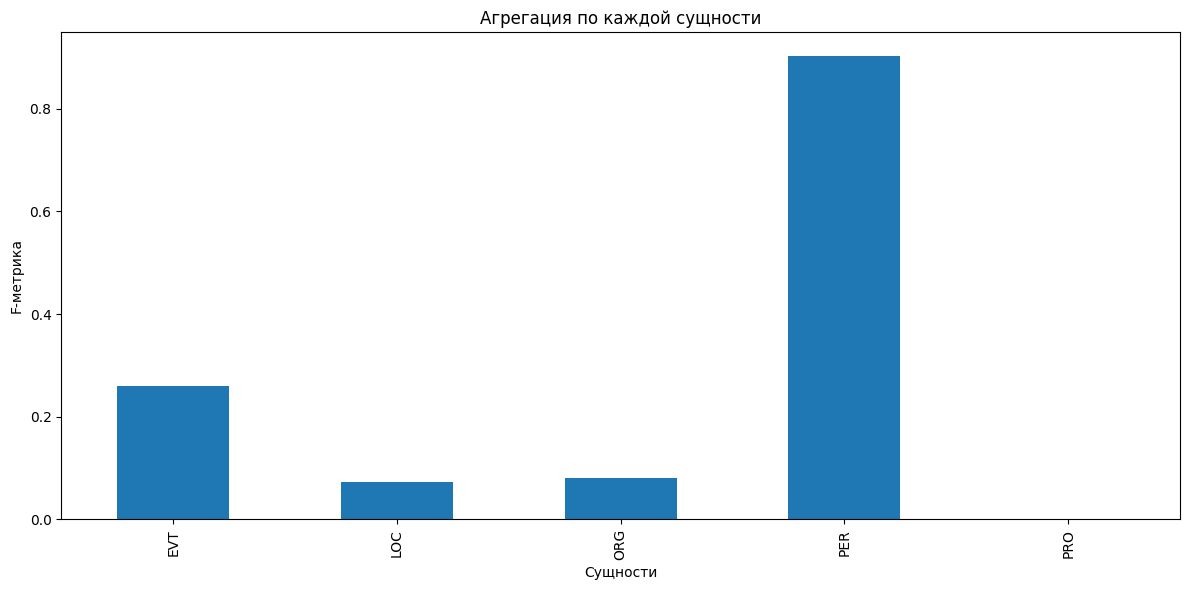

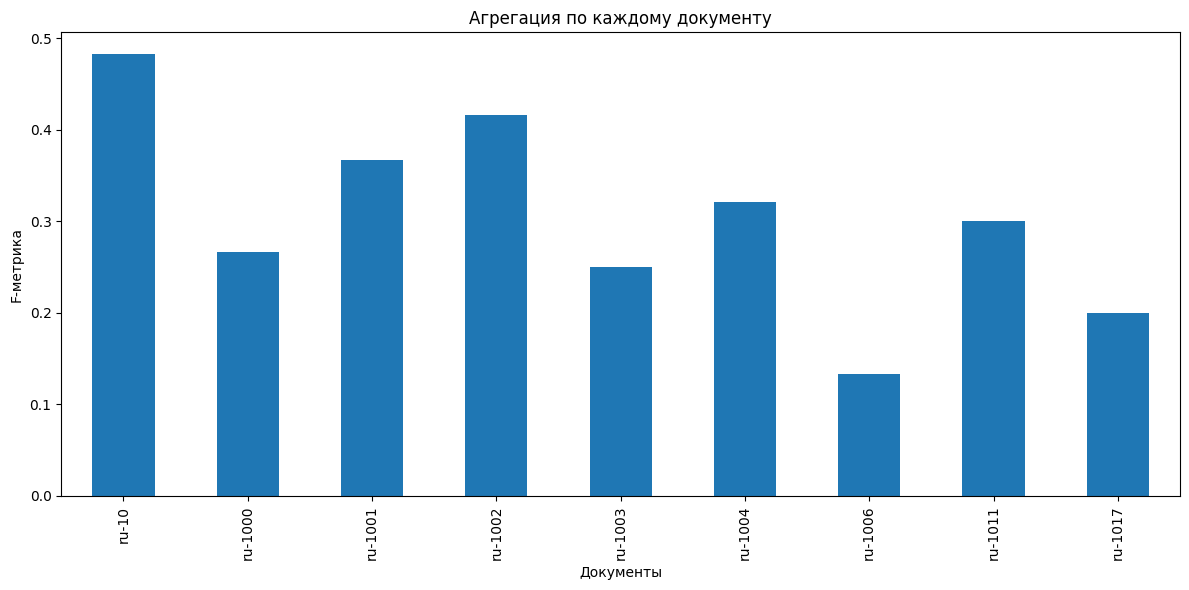

In [27]:
# График 1: По каждой сущности
ent_agg.plot(kind="bar", x='entity', y='score', figsize=(12, 6), legend=False)
plt.title("Агрегация по каждой сущности")
plt.ylabel("F-метрика")
plt.xlabel("Сущности")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# График 2: По каждому документу
doc_agg.plot(kind="bar", x='document_id', y='score', figsize=(12, 6), legend=False)
plt.title("Агрегация по каждому документу")
plt.ylabel("F-метрика")
plt.xlabel("Документы")
plt.tight_layout()
plt.show()

### Выводы:

* **Лучшую точность** модель демонстрирует для определения сущностей **PER(person, личность)**.
* **Худшую - ORG(организации)**, организации бывают составными, например EU и European-Union одно и то же, но нам важно полное совпадение
* Модель **совсем не смогла обнаружить PRO**(товары, бренды), потому что классифицировала 'Guardian' как организацию.

---

* Лучшую, точность модель демпонстрирует для определения сущностей в документе **'ru-10'**, говоря честно, я просто немного "попытал" гигачат("если пытать данные достаточно долго.."), а иначе он выдавал 5 ответов для каждого текста. Возможно это ещё связано с тем, что текст из этого документа большой и не входит в промпт, поэтому я загружал в модель файл.
* **'ru-1002'** - второй, но т.к. это связано с тем, что он сам по себе содержит меньше всего текста, соответственно и меньше сущностей. А это значит, что оценка недостаточно корректна.

## Задание 7:

**Есть ли зависимость метрик от длины документа? Постройте графики, чтобы ответить на вопрос.**

---

In [28]:
# Агрегируем данные по document_id (тут можно было бы использовать doc_agg из прошлого задания, но чтобы не путаться создали новый)
doc_scores = df.groupby("document_id")["score"].mean().reset_index()

# Для каждого document_id берем первый текст(он в каждой строке документа одинаков)
doc_lengths = df.groupby("document_id")["document_text"].first().reset_index()

# Рассчитываем длину текста для каждого документа
doc_lengths['document_length'] = doc_lengths['document_text'].apply(len)

# Объединяем id, метрики и длину текста в один фрейм по doc id
doc_data = pd.merge(doc_scores, doc_lengths[['document_id', 'document_length']], on="document_id")

doc_data

,document_id,score,document_length
0,ru-10,0.482576,5160
1,ru-1000,0.266667,879
2,ru-1001,0.366667,690
3,ru-1002,0.416667,436
4,ru-1003,0.250000,491
5,ru-1004,0.321429,1088
6,ru-1006,0.133333,839
7,ru-1011,0.300000,1641
8,ru-1017,0.200000,955


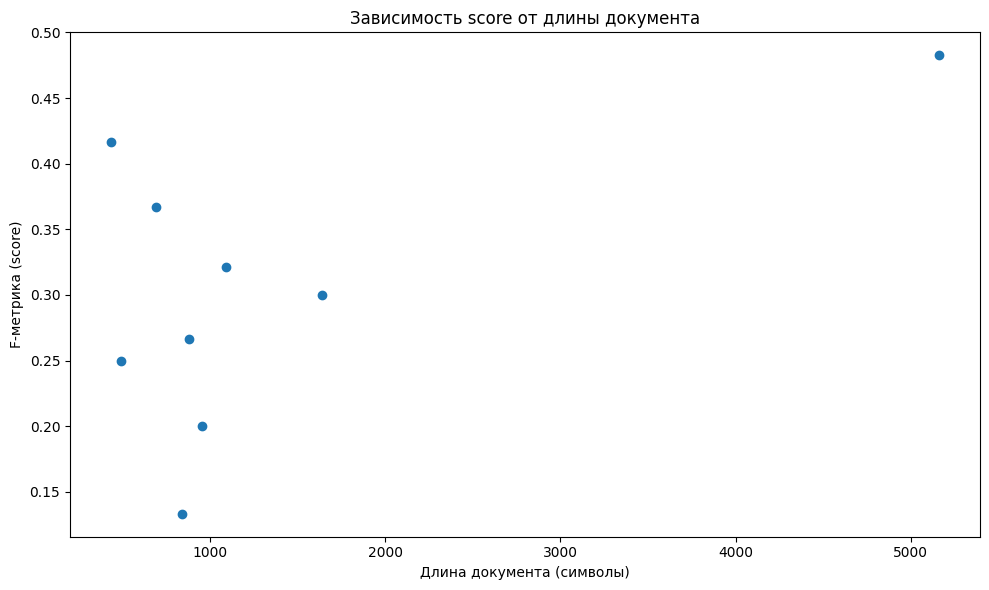

In [29]:
# Scatter plot: Зависимость score от длины документа
plt.figure(figsize=(10, 6))
plt.scatter(data = doc_data, x="document_length", y="score")
plt.title("Зависимость score от длины документа")
plt.xlabel("Длина документа (символы)")
plt.ylabel("F-метрика (score)")
plt.tight_layout()
plt.show()

**Зависимость определённо есть, но имеет смысл вычислить сущности, для текстов с длиной в районе 1000, ещё раз: 'ru-1017' и 'ru-1006', чтобы точнее проследить зависимость.**

## Задание 8:

**Проведите анализ ошибок. Когда модель чаще отвечает правильно, а когда ошибается? Предложите варианты, как повысить метрики.**

---

* Модель отвечает правильнее, когда заставляешь её несколько раз проанализировать текст(изначально выдаёт только 5 ответов или вообще говорит, что в тексте нет сущностей, хотя может это у меня так).
* Попробовав подходы с прикреплением и без прикрепления файла, улучшения не обнаружил.

---

* Вероятно есть **проблема в промпте**, модель путается в брендах и организациях, путает GPE и LOC.
* Для того, чтобы получить ответы приближенные к тем, что описаны в работе, необходимо точнее указать классификации для категорий сущностей, например отправив на анализ ему ["гайд"](https://bsnlp.cs.helsinki.fi/bsnlp-2019/Guidelines_20190122.pdf), но он принимает только один файл и не может пользоваться информацией из разных чатов, а описание в этом гайде очень подробное и не влезет в запрос. Я попросил сделать самари по каждой сущности gpt и вставил его в промпт, но, как видим, сильно ничего не изменилось.

---

Общее решение, состоит в том, чтобы показать LLM текст и размеченный файл(чем больше, тем лучше), а потом попросить выполнить эту задачу для другого текста без подсказок.

## Задание 9:

**Сделайте выводы по всему исследованию. Напишите, чему научились и что нового попробовали.**

---

В целом, если ещё поработать над запросами, тем самым повысить метрики, используя API, можно обращаться к gigachat для решения задач распознавания именованных сущностей. Уже сейчас, в целом, можно просить его распознавать личности в тексте.

---

До выполнения этой задачи, я не знал о распознавании именованных сущностей, конечно я знал, что есть такие заачи и что они решаются, но не знал подробностей.

<br>По итогу я научился решать NER задачи с помощью LLM(оказывается не нужно строить самописную модель через spaCy, если задача небольшая), параллельно попрактиковав промптинг, а также оценивать решения, применив векторизацию оказался в замешательстве :))

<br>Изучил различные этапы(пайплайн) решения таких задач: необходимость использования явно определённого способа классификации каждой сущности, предобработку текста(удаление всяких ссылок и т.п.) и запроса, последующую загрузку ответов, анализ и выявление зависимостей, в т.ч. для улучшения работы модели.

## Выгрузка фрейма с предсказаниями модели:

In [34]:
df.to_csv("giga-output.csv", encoding='utf-8')